In [15]:
import numpy as np
import sympy as sp
from sympy import Symbol
from sympy import solve, Poly, Eq, Function, exp
import math
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks
import os
import imp
import matplotlib.pyplot as plt
import sys

#windows path
#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\') 
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')

#linux path
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/moises/Downloads/'))

In [28]:
def bandwidth(wavelength, response, number_of_points):
    ##number_of_points = Number_of_iteration/2
    max_index = 0
    min_index = 0
    for i in range(number_of_points):
        if response[number_of_points - i]>0.01 and response[number_of_points - (i+1)] < 0.01: ##-30 dB
            min_index = number_of_points - i
            break
        
    for j in range(number_of_points):
        if response[number_of_points + j]>0.01 and response[number_of_points + (j+1)] < 0.01: ##-330 dB
            max_index = number_of_points + j
            break

    return wavelength[min_index], wavelength[max_index]

In [29]:
def FWHM(wavelength, response, number_of_points):
    ##number_of_points = Number_of_iteration/2
    for i in range(number_of_points):
        if 10*np.log10(response[number_of_points - i])> - 3 and 10*np.log10(response[number_of_points - (i+1)]) < -3: ##-3 dB
            min_index = number_of_points - i
            break
        
    for j in range(number_of_points):
        if 10*np.log10(response[number_of_points + j])>-3 and 10*np.log10(response[number_of_points + (j+1)]) < -3: ##-3 dB
            max_index = number_of_points + j
            break

    return wavelength[min_index], wavelength[max_index]

In [16]:
fdtd = lumapi.FDTD(filename= 'bragg.fsp')

In [19]:
P = 348e-9
period = 348.8e-9
N = 150
L = N*period
delta_w = 44.3e-9
w = 450e-9
height = 0.22e-6
material_core = 'Si (Silicon) - Palik Copy 1'
material_subs = 'SiO2 (Glass) - Palik Copy 1'

In [20]:
fdtd.switchtolayout()
fdtd.selectall()
fdtd.delete()

fdtd.addstructuregroup()
fdtd.set('name','corrugation width')

for i in range(N):
    fdtd.addrect()
    fdtd.set({'x min':i*P,
    'x max':i*P + P/2,
    'y':0,
    'y span':w + delta_w,
    'material':material_core})
    fdtd.addtogroup('corrugation width')
    fdtd.addrect()
    fdtd.set({'x min':i*P + P/2,
    'x max':i*P + P/2 + P/2,
    'y':0,
    'y span':w - delta_w,
    'material':material_core})
    fdtd.addtogroup('corrugation width')

fdtd.addrect()
fdtd.set({'name':'rect1',
'x min':-0.5e-6,
'x max':0,
'y':0,
'y span':w,
'z':0,
'z span':height,
'material':material_core})

fdtd.addrect()
fdtd.set({'name':'rect2',
'x min':N*P,
'x max':N*P + 0.5e-6,
'y':0,
'y span':w,
'z':0,
'z span':height,
'material':material_core})

z_span = 4e-6
z_min = -height/2 - z_span
z_max = -height/2
z = (z_min + z_max)/2

fdtd.addrect()
fdtd.set("name", 'substrato')
fdtd.set("x min",-10e-6)
fdtd.set("x max",N*P + 10e-6)
fdtd.set('y',0)
fdtd.set('y span', 10e-6)
fdtd.set('z', z)
fdtd.set('z span', z_span)
fdtd.set('material',material_subs)

In [21]:
fdtd.select('FDTD')
fdtd.delete()
fdtd.addfdtd()
fdtd.set({'x':N*P/2,
'x span':N*P + 0.5e-6,
'y':0,
'y span':3e-6,
'z':0,
'z span':2e-6,
'simulation time':10000e-15,
'x min bc':'PML',
'x max bc':'PML',
'y min bc':'PML',
'y max bc':'PML',
'z min bc':'PML',
'z max bc':'PML'})

fdtd.addport()
fdtd.set({'direction':'Forward',
'x':-0.25e-6,
'y':0,
'y span':2e-6,
'z':0,
'z span':2e-6})
# fdtd.addport()
# fdtd.set({'direction':'Backward',
# 'x':N*P + 0.25e-6,
# 'y':0,
# 'y span':2e-6,
# 'z':0,
# 'z span':2e-6})

fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points', 2000)

fdtd.select('monitor')
fdtd.delete()
fdtd.addpower()
fdtd.set('override global monitor settings',1)
fdtd.set({'frequency points':1000,
'monitor type':'2D X-normal',
'x':-0.2e-6,
'y':0,
'y span':2.5e-6,
'z':0,
'z span':2e-6})

In [24]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

In [139]:
0.06100port 1','T')
R = 1 - abs(result['T'])**2
lambd = result['lambda']

Text(0.5, 1.0, 'period = 338 nm')

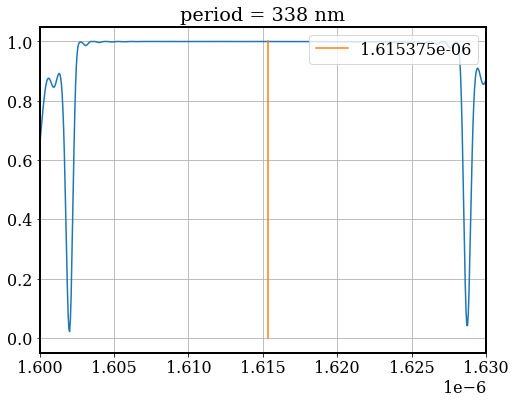

In [156]:
figure = plt.figure(figsize=(8,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, R)
plt.plot([1615.375e-9, 1615.375e-9],[0, 1], label = str(1615.375e-9))
plt.grid(True)
plt.xlim([1600e-9,1630e-9])
plt.legend(loc = 'upper right')
plt.title('period = 338 nm')

In [160]:
result = fdtd.getresult('FDTD::ports::port 1','T')
R = 1 - abs(result['T'])**2 1 watching 
lambd = result['lambda']

Text(0.5, 1.0, 'period = 328 nm')

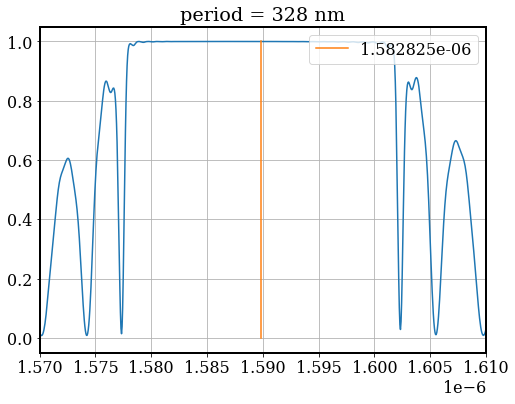

In [168]:
figure = plt.figure(figsize=(8 1 watching ,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, R)
plt.plot([1589.825e-9, 1589.825e-9],[0, 1], label = str(1582.825e-9))
plt.grid(True)
plt.xlim([1570e-9,1610e-9])
plt.legend(loc = 'upper right')
plt.title('period = 328 nm')

In [186]:
result = fdtd.getresult('FDTD::ports::port 1','T')
R = 1 - abs(result['T'])**2
lambd = result['lambda']

Text(0.5, 1.0, 'period = 318 nm')

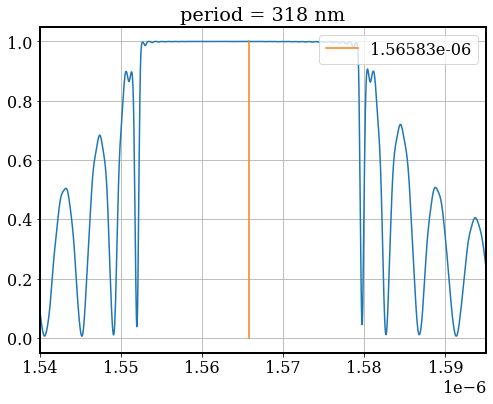

In [188]:
figure = plt.figure(figsize=(8,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, R)
plt.plot([1565.83e-9, 1565.83e-9],[0, 1], label = str(1565.83e-9))
plt.grid(True)
plt.xlim([1540e-9,1595e-9])
plt.legend(loc = 'upper right')
plt.title('period = 318 nm')

In [34]:
result = fdtd.getresult('FDTD::ports::port 1','T')
R = 1 - abs(result['T'])**2
lambd = result['lambda']
band = FWHM(lambd, R,900)
fwhm = abs(band[1][0] - band[0][0])
peak = find_peaks(R, height=0.8)
peak_pos = lambd[peak[0]]

Text(0.5, 1.0, 'period = 348.8 nm')

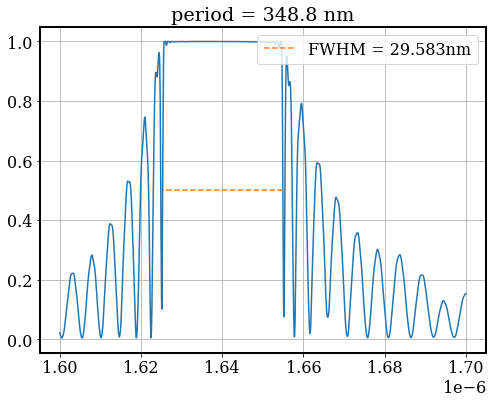

In [33]:
figure = plt.figure(figsize=(8,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, R)
plt.plot([band[0], band[1]], [0.5, 0.5], '--',label = 'FWHM = ' + str(round(fwhm*1e9, 3)) + 'nm')
ax[1].axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
#plt.plot([1565.83e-9, 1565.83e-9],[0, 1], label = str(1565.83e-9))
plt.grid(True)
#plt.xlim([1540e-9,1595e-9])
plt.legend(loc = 'upper right')
plt.title('period = 348.8 nm')


In [50]:
result = fdtd.getresult('FDTD::ports::port 1','T')
R = 1 - abs(result['T'])**2
lambd = result['lambda']

Text(0.5, 1.0, 'Litography')

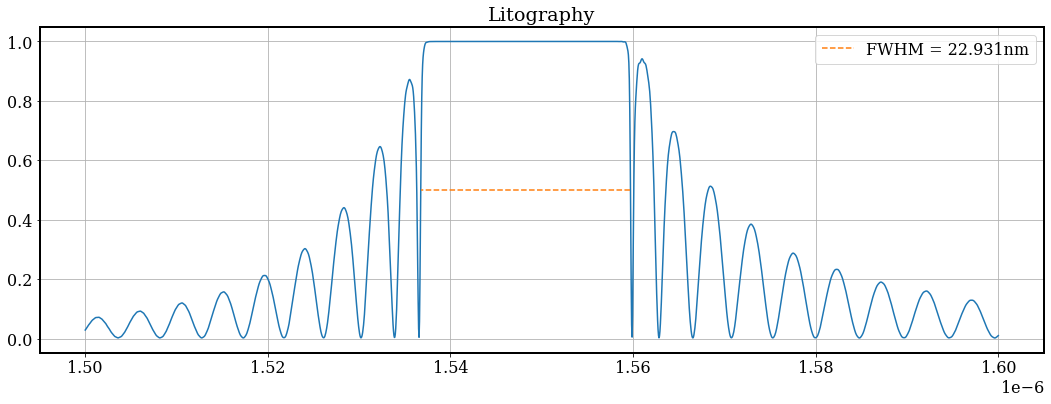

In [67]:
figure = plt.figure(figsize=(18,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, R)
band = FWHM(lambd, R,1000)
fwhm = abs(band[1][0] - band[0][0])
peak = find_peaks(R, height=0.8)
peak_pos = lambd[peak[0]]
#plt.axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
plt.plot([band[0], band[1]], [0.5, 0.5], '--',label = 'FWHM = ' + str(round(fwhm*1e9, 3)) + 'nm')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.title('Litography')

Text(0.5, 1.0, 'Litography')

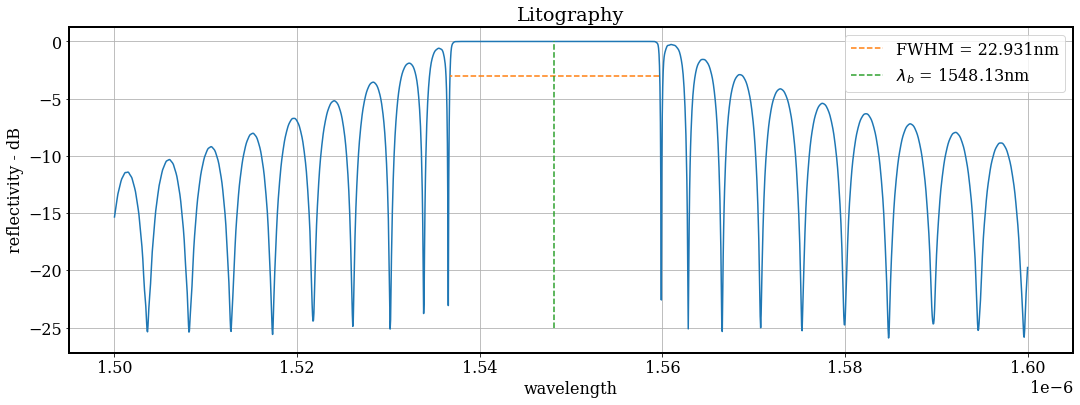

In [75]:
figure = plt.figure(figsize=(18,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(lambd, 10*np.log10(R))
band = FWHM(lambd, R,1000)
fwhm = abs(band[1][0] - band[0][0])
peak = find_peaks(R, height=0.8)
peak_pos = lambd[peak[0]]
peak_r = 1548.13e-9
#plt.axvline(x = peak_pos, linestyle = '--',color = 'black', label ='$\lambda_b$ = ' + str(round(peak_pos[0][0]*1e9, 3))+" nm")
plt.plot([band[0], band[1]], [-3, -3], '--',label = 'FWHM = ' + str(round(fwhm*1e9, 3)) + 'nm')
plt.plot([peak_r, peak_r], [-25, 0], '--',label = '$\lambda_b$ = ' + str(round(peak_r*1e9, 3)) + 'nm')
plt.grid(True)
plt.xlabel("wavelength")
plt.ylabel('reflectivity - dB')
plt.legend(loc = 'upper right')
plt.title('Litography')

In [71]:
peak = find_peaks(10*np.log10(R), height=-0.001)
peak_pos = lambd[peak[0]]
peak_pos

array([[1.55872510e-06],
       [1.55826946e-06],
       [1.55796584e-06],
       [1.55781407e-06],
       [1.55756120e-06],
       [1.55740951e-06],
       [1.55715677e-06],
       [1.55700516e-06],
       [1.55675255e-06],
       [1.55660102e-06],
       [1.55634854e-06],
       [1.55619709e-06],
       [1.55594474e-06],
       [1.55574291e-06],
       [1.55554115e-06],
       [1.55533943e-06],
       [1.55513776e-06],
       [1.55493615e-06],
       [1.55468421e-06],
       [1.55453308e-06],
       [1.55428127e-06],
       [1.55413022e-06],
       [1.55387854e-06],
       [1.55372757e-06],
       [1.55347602e-06],
       [1.55332513e-06],
       [1.55307371e-06],
       [1.55292290e-06],
       [1.55267161e-06],
       [1.55252087e-06],
       [1.55226971e-06],
       [1.55211906e-06],
       [1.55186803e-06],
       [1.55171745e-06],
       [1.55141638e-06],
       [1.55131604e-06],
       [1.55101513e-06],
       [1.55091485e-06],
       [1.55061409e-06],
       [1.55051386e-06],
